In [1]:
import os
from PIL import Image, ImageFilter
import numpy as np 

#Dataset Directory 
alphabet_dir = "ASL_Dataset/Train"
 
images = []
labels = []

In [2]:
max_images_per_folder = 800
size = (256, 256)  
def horizontal_flip(image):
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return flipped_image

# Noise removal: Gaussian blur
def remove_noise(image):
    pil_image = Image.fromarray(np.uint8(image*255))  
    denoised_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
    denoised_array = np.array(denoised_image) / 255.0  
    return denoised_array

images = []
labels = []

for folder_name in os.listdir(alphabet_dir):
    folder_path = os.path.join(alphabet_dir, folder_name)

    image_counter = 0

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            if image_counter >= max_images_per_folder:
                break
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            image = image.resize(size)

            image = image.convert('L')

            image = np.array(image) / 255.0

            image = remove_noise(image)

            images.append(image)
            labels.append(folder_name)
            image_counter += 1

images = np.array(images)
labels = np.array(labels)

In [3]:
images.shape

(22400, 256, 256)

# PCA

In [4]:
num_images = images.shape[0]
flattened_images = images.reshape(num_images, -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_images = scaler.fit_transform(flattened_images)

In [5]:
from sklearn.decomposition import PCA

num_components = 10  # Number of principal components to keep
pca = PCA(n_components=num_components)
reduced_images = pca.fit_transform(standardized_images)
reconstructed_images = pca.inverse_transform(reduced_images)

In [6]:
reconstructed_images.shape

(22400, 65536)

In [7]:
import cupy as cp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X = reduced_images
y = labels

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.8, stratify=y)

X_labeled = cp.asarray(X_labeled)
y_labeled = cp.asarray(y_labeled)
X_unlabeled = cp.asarray(X_unlabeled)
y_unlabeled = cp.asarray(y_unlabeled)

classifier = DecisionTreeClassifier(max_depth=12, criterion='entropy', random_state=2411)

confidence_threshold = 0.9
num_iterations = 5

for i in range(num_iterations):
    classifier.fit(X_labeled.get(), y_labeled.get())
    y_pred = cp.asarray(classifier.predict(X_unlabeled.get()))

    # Select high-confidence predictions
    y_pred_prob = cp.asarray(classifier.predict_proba(X_unlabeled.get()))
    max_probs = cp.max(y_pred_prob, axis=1)
    high_confidence_indices = cp.where(max_probs >= confidence_threshold)[0]
    pseudo_labels = y_pred[high_confidence_indices]

    # Add high-confidence examples to the labeled data
    X_labeled = cp.concatenate([X_labeled, X_unlabeled[high_confidence_indices]])
    y_labeled = cp.concatenate([y_labeled, pseudo_labels])

    print(f"Iteration {i + 1}: Labeled Data Size - {X_labeled.shape[0]}, Unlabeled Data Size - {X_unlabeled.shape[0]}")

y_pred = cp.asarray(classifier.predict(X_unlabeled.get()))
accuracy = accuracy_score(y_unlabeled.get(), y_pred.get())
print("Accuracy:", accuracy)


Iteration 1: Labeled Data Size - 22079, Unlabeled Data Size - 17920
Iteration 2: Labeled Data Size - 39075, Unlabeled Data Size - 17920
Iteration 3: Labeled Data Size - 56267, Unlabeled Data Size - 17920
Iteration 4: Labeled Data Size - 73479, Unlabeled Data Size - 17920
Iteration 5: Labeled Data Size - 90504, Unlabeled Data Size - 17920
Accuracy: 0.88203125


In [9]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(y_unlabeled.get(), y_pred.get(), average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Precision: 0.8828152423075395
Recall: 0.88203125
F1-score: 0.8818948396100289


In [11]:
from sklearn.metrics import classification_report

report = classification_report(y_unlabeled.get(), y_pred.get())
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       640
           1       0.91      0.82      0.86       640
           2       0.94      0.88      0.91       640
           3       0.92      0.93      0.93       640
           4       0.84      0.94      0.89       640
           5       0.93      0.93      0.93       640
           6       0.91      0.89      0.90       640
           7       0.89      0.92      0.91       640
           8       0.84      0.86      0.85       640
           9       0.90      0.88      0.89       640
          10       0.89      0.86      0.88       640
          11       0.85      0.96      0.90       640
          12       0.86      0.89      0.88       640
          13       0.84      0.83      0.83       640
          14       0.99      0.99      0.99       640
          15       0.89      0.85      0.87       640
          16       0.94      0.93      0.93       640
    

In [13]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(y_unlabeled.get(), y_pred.get())
print("Balanced Accuracy:", balanced_accuracy)

Balanced Accuracy: 0.88203125


In [14]:
from sklearn.metrics import confusion_matrix

y_unlabeled_np = cp.asnumpy(y_unlabeled)
y_pred_np = cp.asnumpy(y_pred)

# Compute confusion matrix
confusion_mat = confusion_matrix(y_unlabeled_np, y_pred_np)
# print("Confusion Matrix:")
# print(confusion_mat)

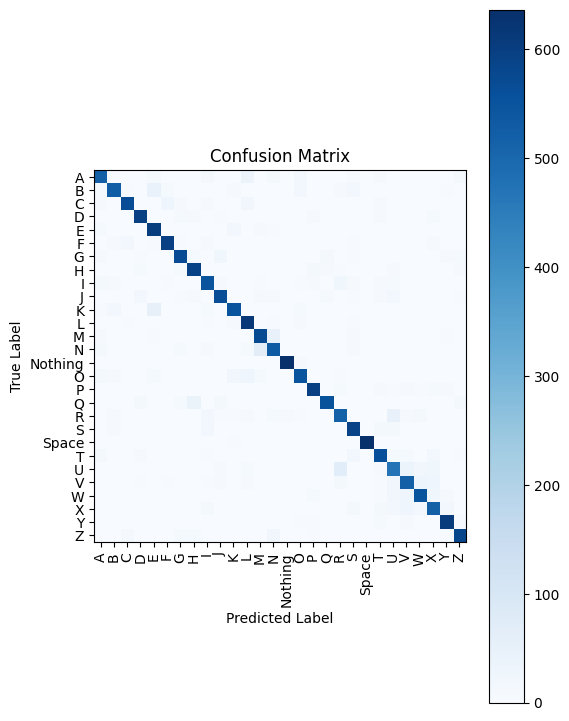

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 9))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=90)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()